# Importing and installing important Lib 

In [148]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
import tweepy
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
stop = stopwords.words('english')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import re
import matplotlib.pyplot as plt
from matplotlib.cm import Reds, Greens, Purples, Greys
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
crypto_list=['@Bitcoin','@ethereum','@litecoin','@Tether_to','@dogecoin','@Polkadot','@btc',"@Cardano"]

In [151]:
hashtags = ['#cryptocurrency' ,'#crypto',  '#cryptotrading', '#cryptonews' ,'#cryptomining' ,'#cryptoworld', '#cryptolife' ,'#cryptotrader' ,'#cryptoinvestor', '#cryptocurrencynews']

# Connecting with twitter using Tweepy

In [152]:
# Variables that contains the credentials to access Twitter API
access_token='1394853041178873858-x6pAsbKjdYz0XDuV11sXNDI5BpaLGm'
access_token_secret='lbCEyVRKK4Pq6rGOm8G9coMC35gkUn0qDwyPIQQZrMavs'
consumer_key='IeYEcmFchOieMPWKcxum7md57'
consumer_secret='71XjcZIBC8UkYgf0XkSJAdOi9NdJbE7bjiRnrfHX3a5IW1iPh5'


# Setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)   #api key and secret 
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth)
    return api


# Create API object
api = connect_to_twitter_OAuth()

In [153]:
# Array to hold tweet data
tweet_list = []
# Iterate through all the crypto_list
for crypto in crypto_list:
    # Bring out the 200 tweets
    crypto_tweets = api.user_timeline(screen_name=crypto)    
    
    # Loop through the 200 tweets
    for tweet in crypto_tweets:
        tweet_id = tweet.id # unique integer identifier for tweet
        text = tweet.text # utf-8 text of tweet
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at # utc time tweet created
        source = tweet.source # utility used to post tweet
        reply_to_status = tweet.in_reply_to_status_id # if reply int of orginal tweet id
        reply_to_user = tweet.in_reply_to_screen_name # if reply original tweetes screenname
        retweets = tweet.retweet_count # number of times this tweet retweeted
        favorites = tweet.favorite_count # number of time this tweet liked
        # append attributes to list
        tweet_list.append({'crypto':crypto,
                          'tweet_id':tweet_id, 
                          'text':text, 
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          'reply_to_status':reply_to_status, 
                          'reply_to_user':reply_to_user,
                          'retweets':retweets,
                          'favorites':favorites})
        

## EDA on Data

In [154]:
tweet_data=pd.DataFrame(tweet_list)
tweet_data.head()

,crypto,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,favorites
0,@Bitcoin,1645873385178828805,"RT @PompPodcast: In the analog world, it's all...",0,90,2023-04-11 19:36:08+00:00,Twitter Web App,NaN,None,90,0
1,@Bitcoin,1645561760903208960,RT @RobertKennedyJr: The claim that FedNow is ...,0,7628,2023-04-10 22:57:51+00:00,Twitter Web App,NaN,None,7628,0
2,@Bitcoin,1644742342656786434,RT @CaitlinLong_: THE FED RELEASED THIS YESTER...,0,470,2023-04-08 16:41:46+00:00,Twitter Web App,NaN,None,470,0
3,@Bitcoin,1644467492105105409,https://t.co/AoYT5kszND https://t.co/UbmjLuAm5t,299,152,2023-04-07 22:29:37+00:00,Twitter Web App,NaN,None,152,299
4,@Bitcoin,1644441008133001217,RT @JasonPLowery: 98%\n\nThe #Bitcoin #SOFTWAR...,0,155,2023-04-07 20:44:23+00:00,Twitter Web App,NaN,None,155,0


In [155]:
tweet_data.shape

(160, 11)

In [156]:
data=tweet_data.copy()

In [157]:
source=data.source.value_counts()
source

Twitter Web App            59
Twitter for iPhone         27
TweetDeck                  23
Hootsuite Inc.             20
Buffer                     16
Twitter for Android        13
Twitter for Advertisers     1
HubSpot                     1
Name: source, dtype: int64

In [158]:
trace=go.Pie(labels=source.index,values=source,showlegend=False,hole=0.33,text=[str(round(i*100,3))+'%' for i in source/sum(source)],hovertext='Source',
            hoverinfo='label+text',textinfo='text+label'
            )
layout=go.Layout(title="Which Device People are using?")
fig=go.Figure(data=[trace],layout=layout)
fig.show()

In [159]:
source=data.groupby('crypto').agg(sum)[['retweet_count','favorite_count']]

<ipython-input-159-c1c9d70ae026>:1: FutureWarning:

The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.



In [160]:
fig=go.Figure()
fig.add_bar(x=source.index,y=source.retweet_count,name='Retweet Count')
fig.add_bar(x=source.index,y=source.favorite_count,name='Favorite Count')

In [161]:
def hashtag_extract(x):                # extracting hastags 
    hashtags = []
    ht = re.findall(r"#(\w+)", x)
    hashtags.extend(ht)                  
    if hashtags==[]:                     # if no hastags are used in text 
        return ''
    return hashtags                     # if hastags are used 

In [162]:
tags=[hashtag_extract(x.lower()) for  x in data.text]
tags

['',
 '',
 ['fednow'],
 '',
 ['bitcoin', 'softwar'],
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ['bitcoin'],
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ['litecoin'],
 ['crypto'],
 '',
 ['themandalorian'],
 '',
 ['litecoin'],
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ['crypto'],
 '',
 '',
 ['litecoin'],
 ['litecoin', 'doge', 'mergemining', 'iykyk'],
 '',
 ['litecoin'],
 '',
 '',
 ['tether', 'bitcoin'],
 ['tether', 'tether'],
 '',
 ['tether'],
 ['tether', 'tether'],
 ['bitcoin', 'tether'],
 '',
 '',
 ['bitcoin', 'tether'],
 ['tether'],
 '',
 ['tether'],
 '',
 ['tether'],
 '',
 ['tether'],
 ['bitcoin', 'tether', 'lvga', 'luganoplanb'],
 ['luganoplanb', 'bitcoin', 'tether'],
 '',
 '',
 '',
 '',
 '',
 ['doge', 'dogecoin'],
 '',
 '',
 '',
 ['dogecoin'],
 ['dogecoin'],
 '',
 ['dogefam'],
 ['dogecoin', 'doge'],
 '',
 '',
 ['dogefam', 'dogemas'],
 ['dogecoin', 'dogefam'],
 '',
 ['dogeathon'],
 ['consensus2023'],
 ''

In [163]:
all_tags=[]
for tag in tags:
    if tag!='':                                         # extracting only hastags
        all_tags.extend(tag)
all_tags

['fednow',
 'bitcoin',
 'softwar',
 'bitcoin',
 'litecoin',
 'crypto',
 'themandalorian',
 'litecoin',
 'crypto',
 'litecoin',
 'litecoin',
 'doge',
 'mergemining',
 'iykyk',
 'litecoin',
 'tether',
 'bitcoin',
 'tether',
 'tether',
 'tether',
 'tether',
 'tether',
 'bitcoin',
 'tether',
 'bitcoin',
 'tether',
 'tether',
 'tether',
 'tether',
 'tether',
 'bitcoin',
 'tether',
 'lvga',
 'luganoplanb',
 'luganoplanb',
 'bitcoin',
 'tether',
 'doge',
 'dogecoin',
 'dogecoin',
 'dogecoin',
 'dogefam',
 'dogecoin',
 'doge',
 'dogefam',
 'dogemas',
 'dogecoin',
 'dogefam',
 'dogeathon',
 'consensus2023',
 'polkadotdigest',
 'polkadot',
 'polkadotcommunitycall',
 'polkadotdigest',
 'polkadot',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'bitcoin',
 'aiken',
 'aiken',
 'aiken',
 'cardano',
 'aiken',
 'aiken',
 'plutus',
 'aiken',
 'plutus',
 'aiken',
 'smartc

In [164]:
def count_hastags(tag_list):
  dic={}
  for tags in tag_list:
    if tags in dic.keys():
      dic[tags]+=1
    else:
      dic[tags]=1
  return dic

In [165]:
hash_tag_count=count_hastags(all_tags)

In [166]:
import collections
import matplotlib.pyplot as plt

# Count the elements in the dictionary and get the top 10
counter = collections.Counter(hash_tag_count)
top10 = dict(counter.most_common(10))




In [167]:
color_scale = 'RdYlBu'
fig=go.Figure()
fig.add_bar(x=list(top10.keys()),
    y=list(top10.values()),
    marker=dict(color=list(top10.values()), colorscale=color_scale))


# Add labels to the figure
fig.update_layout(
    title='Top 10 Hastags in count',
    xaxis_title='Hashtags',
    yaxis_title='Count')
# Display the figure
fig.show()



#Data wrangling

In [168]:
# removing user handle 
data['tidy_tweet'] = data['text'].replace(to_replace ='(@[\w]+)', value ='', regex = True)     # removing mentions 
data['tidy_tweet'] = data['tidy_tweet'].replace(to_replace =('RT'), value ='',regex = True)       #removing RT
data['tidy_tweet'] = data['tidy_tweet'].str.replace('((www\.[\s]+)|(https?://[^\s]+))','\0',regex=True)    # removing all the web links 
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z]+", " ") # remove special characters, numbers, punctuations: None of them would add any value to the sentiment score.
data['tidy_tweet']

<ipython-input-168-07e90bfa9374>:5: FutureWarning:

The default value of regex will change from True to False in a future version.



0       In the analog world it s all about offense In...
1       The claim that FedNow is not the first step t...
2       THE FED RELEASED THIS YESTERDAY it s playing ...
3                                                       
4       The Bitcoin SOFTWAR has already mostly been w...
                             ...                        
155     This coming Wednesday April th at pm EST I ll...
156    Are you signed up yet Don t miss out on this i...
157     Just finished Cardano Foundation Blockchain E...
158     You know someone who doesn t know anything ab...
159     Did you miss the Alpha Sign up for the next c...
Name: tidy_tweet, Length: 160, dtype: object

**Tokenising,Removing Stop Words and Lamatizing**

In [169]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download the stop words
nltk.download('stopwords')
stop = stopwords.words('english')

# Download the WordNet lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Lowercase the data
data["tidy_tweet"] = data["tidy_tweet"].str.lower()

# Tokenize the data
data["tidy_tweet"] = data["tidy_tweet"].str.split()

# Remove stop words and lemmatize the tokens
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: [lemmatizer.lemmatize(item) for item in x if item not in stop])




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [170]:
# Display the dataframe
data["tidy_tweet"]

0      [analog, world, offense, digital, world, defen...
1      [claim, fednow, first, step, toward, cbdc, wou...
2      [fed, released, yesterday, playing, defense, f...
3                                                     []
4      [bitcoin, softwar, already, mostly, imo, wait,...
                             ...                        
155    [coming, wednesday, april, th, pm, est, hostin...
156    [signed, yet, miss, incredible, event, hosted,...
157    [finished, cardano, foundation, blockchain, ed...
158    [know, someone, know, anything, blockchain, sh...
159    [miss, alpha, sign, next, cohort, let, know, n...
Name: tidy_tweet, Length: 160, dtype: object

In [171]:
def rejoin_words(row):
    my_list = row['tidy_tweet']
    joined_words = ( " ".join(my_list))
    return joined_words

data['tidy_tweet'] = data.apply(rejoin_words, axis=1)
data['tidy_tweet']

0      analog world offense digital world defense bit...
1      claim fednow first step toward cbdc would easi...
2      fed released yesterday playing defense fednow ...
3                                                       
4      bitcoin softwar already mostly imo wait leader...
                             ...                        
155    coming wednesday april th pm est hosting hour ...
156         signed yet miss incredible event hosted spec
157    finished cardano foundation blockchain educati...
158    know someone know anything blockchain share th...
159    miss alpha sign next cohort let know next batc...
Name: tidy_tweet, Length: 160, dtype: object

#Check the Sentiment using diffrent models

**TextBlob**

In [172]:
from textblob import TextBlob

# Define a function to get the sentiment polarity of a tweet
def get_tweet_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Return the polarity score
    return analysis.sentiment.polarity

# Define a function to get the sentiment category of a polarity score
def get_sentiment_category(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis functions to each tweet in the dataframe
data['polarity_textblob'] = data['tidy_tweet'].apply(lambda x: get_tweet_sentiment(x))
data['sentiment_textblob'] = data['polarity_textblob'].apply(lambda x: get_sentiment_category(x))

# Display the dataframe
data.head()


,crypto,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,favorites,tidy_tweet,polarity_textblob,sentiment_textblob
0,@Bitcoin,1645873385178828805,"RT @PompPodcast: In the analog world, it's all...",0,90,2023-04-11 19:36:08+00:00,Twitter Web App,NaN,None,90,0,analog world offense digital world defense bit...,0.000000,neutral
1,@Bitcoin,1645561760903208960,RT @RobertKennedyJr: The claim that FedNow is ...,0,7628,2023-04-10 22:57:51+00:00,Twitter Web App,NaN,None,7628,0,claim fednow first step toward cbdc would easi...,0.311111,positive
2,@Bitcoin,1644742342656786434,RT @CaitlinLong_: THE FED RELEASED THIS YESTER...,0,470,2023-04-08 16:41:46+00:00,Twitter Web App,NaN,None,470,0,fed released yesterday playing defense fednow ...,0.000000,neutral
3,@Bitcoin,1644467492105105409,https://t.co/AoYT5kszND https://t.co/UbmjLuAm5t,299,152,2023-04-07 22:29:37+00:00,Twitter Web App,NaN,None,152,299,,0.000000,neutral
4,@Bitcoin,1644441008133001217,RT @JasonPLowery: 98%\n\nThe #Bitcoin #SOFTWAR...,0,155,2023-04-07 20:44:23+00:00,Twitter Web App,NaN,None,155,0,bitcoin softwar already mostly imo wait leader...,0.500000,positive


In [173]:
source=data.groupby('crypto').agg('mean')
source

<ipython-input-173-82ac5db99e48>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,tweet_id,favorite_count,retweet_count,reply_to_status,retweets,favorites,polarity_textblob
crypto,,,,,,,
@Bitcoin,1.642437e+18,80.40,2385.55,NaN,2385.55,80.40,0.029770
@Cardano,1.646011e+18,59.45,36.20,1.646576e+18,36.20,59.45,0.128754
@Polkadot,1.646150e+18,140.55,27.65,1.646112e+18,27.65,140.55,0.108750
@Tether_to,1.642951e+18,85.00,44.60,NaN,44.60,85.00,0.128710
@btc,1.646253e+18,11.80,274.50,NaN,274.50,11.80,0.043068
@dogecoin,1.625877e+18,3908.10,5007.95,1.608610e+18,5007.95,3908.10,0.150909
@ethereum,1.637027e+18,0.00,352.70,NaN,352.70,0.00,0.111136
@litecoin,1.644864e+18,657.95,130.35,NaN,130.35,657.95,0.115136


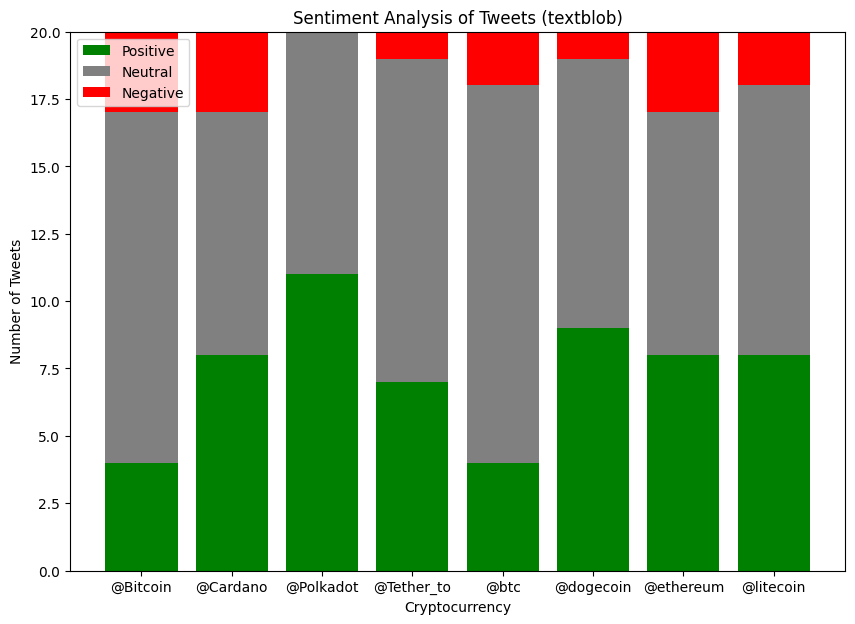

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by cryptocurrency and sentiment
grouped_data = data.groupby(['crypto', 'sentiment_textblob']).size().unstack(fill_value=0)

# Define the colors for each sentiment
colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

# Create the stacked bar chart
plt.figure(figsize=(10,7))
plt.bar(grouped_data.index, grouped_data['positive'], color=colors['positive'], label='Positive')
plt.bar(grouped_data.index, grouped_data['neutral'], bottom=grouped_data['positive'], color=colors['neutral'], label='Neutral')
plt.bar(grouped_data.index, grouped_data['negative'], bottom=grouped_data['positive']+grouped_data['neutral'], color=colors['negative'], label='Negative')

# Set the title and labels
plt.title('Sentiment Analysis of Tweets (textblob)')
plt.xlabel('Cryptocurrency')
plt.ylabel('Number of Tweets')
plt.legend()

# Show the chart
plt.show()


**Vader Sentimental Abalysis**

In [175]:
analyzer = SentimentIntensityAnalyzer()
out={'neg':[],'neu':[],'pos':[],'compound':[]}
for i in range(data.shape[0]):
    vader_out=analyzer.polarity_scores(data.tidy_tweet[i])
    for key in vader_out.keys():
        out[key].append(vader_out[key])
for key in out.keys():
    data[key]=out[key]

source=data.groupby('crypto').agg('mean')
source


<ipython-input-175-f260bb01b705>:10: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,tweet_id,favorite_count,retweet_count,reply_to_status,retweets,favorites,polarity_textblob,neg,neu,pos,compound
crypto,,,,,,,,,,,
@Bitcoin,1.642437e+18,80.40,2385.55,NaN,2385.55,80.40,0.029770,0.03300,0.71875,0.14825,0.123335
@Cardano,1.646011e+18,59.45,36.20,1.646576e+18,36.20,59.45,0.128754,0.04690,0.73645,0.21665,0.261610
@Polkadot,1.646150e+18,140.55,27.65,1.646112e+18,27.65,140.55,0.108750,0.02545,0.81140,0.16315,0.204080
@Tether_to,1.642951e+18,85.00,44.60,NaN,44.60,85.00,0.128710,0.00000,0.71010,0.23990,0.264520
@btc,1.646253e+18,11.80,274.50,NaN,274.50,11.80,0.043068,0.04915,0.83865,0.11220,0.035020
@dogecoin,1.625877e+18,3908.10,5007.95,1.608610e+18,5007.95,3908.10,0.150909,0.01290,0.47235,0.26475,0.315320
@ethereum,1.637027e+18,0.00,352.70,NaN,352.70,0.00,0.111136,0.00835,0.77660,0.21505,0.315685
@litecoin,1.644864e+18,657.95,130.35,NaN,130.35,657.95,0.115136,0.02080,0.79530,0.13390,0.151300


In [176]:
fig=go.Figure()
for crypto in data.crypto.unique():
    fig.add_bar(x=['Negative','Neutral','Positive','Compound'],y=list(source[source.index==crypto][out.keys()].values[0]),name=crypto)
fig.update_layout(title='Average Sentiment Across type of cryptocurrencies using Vader Sentiment')
fig.show()

**Roberta Sentimental Analysis**

In [177]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [179]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [180]:
def polarity_score_roberta(exe):
  encoded_text=tokenizer("exe",return_tensors="pt")
  output=model(**encoded_text)
  roberta=output[0][0].detach().numpy()
  roberta=softmax(roberta)
  roberta_dict={"r_neg":roberta[0],
                "r_neu":roberta[1],
                "r_pos":roberta[2]}
  return(roberta_dict)

In [181]:
out_r={'r_neg':[],'r_neu':[],'r_pos':[]}

In [182]:
for i in range(data.shape[0]):
  
    roberta_out=polarity_score_roberta(data.tidy_tweet[i])
    for key in roberta_out.keys():
        out_r[key].append(roberta_out[key])

In [183]:
for key in out_r.keys():
    data[key]=out_r[key]

In [184]:
data['roberta_sentiment'] = ['positive' if (x['r_pos'] >= x['r_neg']) else 'negative' for i, x in data.iterrows()]
data

,crypto,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,...,polarity_textblob,sentiment_textblob,neg,neu,pos,compound,r_neg,r_neu,r_pos,roberta_sentiment
0,@Bitcoin,1645873385178828805,"RT @PompPodcast: In the analog world, it's all...",0,90,2023-04-11 19:36:08+00:00,Twitter Web App,NaN,None,90,...,0.000000,neutral,0.161,0.484,0.355,0.3400,0.21761,0.604207,0.178183,negative
1,@Bitcoin,1645561760903208960,RT @RobertKennedyJr: The claim that FedNow is ...,0,7628,2023-04-10 22:57:51+00:00,Twitter Web App,NaN,None,7628,...,0.311111,positive,0.000,0.806,0.194,0.3400,0.21761,0.604207,0.178183,negative
2,@Bitcoin,1644742342656786434,RT @CaitlinLong_: THE FED RELEASED THIS YESTER...,0,470,2023-04-08 16:41:46+00:00,Twitter Web App,NaN,None,470,...,0.000000,neutral,0.000,0.602,0.398,0.3182,0.21761,0.604207,0.178183,negative
3,@Bitcoin,1644467492105105409,https://t.co/AoYT5kszND https://t.co/UbmjLuAm5t,299,152,2023-04-07 22:29:37+00:00,Twitter Web App,NaN,None,152,...,0.000000,neutral,0.000,0.000,0.000,0.0000,0.21761,0.604207,0.178183,negative
4,@Bitcoin,1644441008133001217,RT @JasonPLowery: 98%\n\nThe #Bitcoin #SOFTWAR...,0,155,2023-04-07 20:44:23+00:00,Twitter Web App,NaN,None,155,...,0.500000,positive,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,@Cardano,1645792044949069826,"RT @Quantumplation: This coming Wednesday, Apr...",0,36,2023-04-11 14:12:55+00:00,Twitter for iPhone,NaN,None,36,...,0.000000,neutral,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative
156,@Cardano,1644368686751571969,Are you signed up yet? 📝\nDon’t miss out on th...,116,27,2023-04-07 15:57:00+00:00,Twitter for iPhone,NaN,None,27,...,0.900000,positive,0.211,0.789,0.000,-0.1531,0.21761,0.604207,0.178183,negative
157,@Cardano,1644367236721954818,RT @andreassosilo: Just finished Cardano Found...,0,34,2023-04-07 15:51:14+00:00,Twitter for iPhone,NaN,None,34,...,0.160000,positive,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative
158,@Cardano,1644283185079939072,RT @MauroAndreoliA: You know someone who doesn...,0,77,2023-04-07 10:17:15+00:00,Twitter for iPhone,NaN,None,77,...,0.000000,neutral,0.000,0.732,0.268,0.2960,0.21761,0.604207,0.178183,negative


In [185]:
data['roberta_sentiment']=='positive'

0      False
1      False
2      False
3      False
4      False
       ...  
155    False
156    False
157    False
158    False
159    False
Name: roberta_sentiment, Length: 160, dtype: bool

In [186]:
source_r=data.groupby('crypto').agg('mean')
fig=go.Figure()
for crypto in data.crypto.unique():
    fig.add_bar(x=['r_neg','r_neu','r_pos'],y=list(source_r[source_r.index==crypto][out_r.keys()].values[0]),name=crypto)
fig.update_layout(title='Average Sentiment Across type of cryptocurrencies using roberta-base-sentiment')
fig.show()

<ipython-input-186-73a1342767ff>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



**Distilbert-Base-Uncased Sentimental Analysis**

In [187]:
from transformers import pipeline
sent_pipeline=pipeline("sentiment-analysis",)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [188]:
def polarity_score_bert(exe):
  bert_dict={"label":sent_pipeline[0]
                }
  return(bert_dict)

In [189]:
labels=[]
for i in range(data.shape[0]):
  
    bert_out=sent_pipeline(data.tidy_tweet[i])
    labels.append(bert_out[0])

In [190]:
data=pd.concat([data,pd.DataFrame(labels)],axis=1)
data

,crypto,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,...,neg,neu,pos,compound,r_neg,r_neu,r_pos,roberta_sentiment,label,score
0,@Bitcoin,1645873385178828805,"RT @PompPodcast: In the analog world, it's all...",0,90,2023-04-11 19:36:08+00:00,Twitter Web App,NaN,None,90,...,0.161,0.484,0.355,0.3400,0.21761,0.604207,0.178183,negative,NEGATIVE,0.981775
1,@Bitcoin,1645561760903208960,RT @RobertKennedyJr: The claim that FedNow is ...,0,7628,2023-04-10 22:57:51+00:00,Twitter Web App,NaN,None,7628,...,0.000,0.806,0.194,0.3400,0.21761,0.604207,0.178183,negative,NEGATIVE,0.987489
2,@Bitcoin,1644742342656786434,RT @CaitlinLong_: THE FED RELEASED THIS YESTER...,0,470,2023-04-08 16:41:46+00:00,Twitter Web App,NaN,None,470,...,0.000,0.602,0.398,0.3182,0.21761,0.604207,0.178183,negative,NEGATIVE,0.984340
3,@Bitcoin,1644467492105105409,https://t.co/AoYT5kszND https://t.co/UbmjLuAm5t,299,152,2023-04-07 22:29:37+00:00,Twitter Web App,NaN,None,152,...,0.000,0.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,POSITIVE,0.748121
4,@Bitcoin,1644441008133001217,RT @JasonPLowery: 98%\n\nThe #Bitcoin #SOFTWAR...,0,155,2023-04-07 20:44:23+00:00,Twitter Web App,NaN,None,155,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.999112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,@Cardano,1645792044949069826,"RT @Quantumplation: This coming Wednesday, Apr...",0,36,2023-04-11 14:12:55+00:00,Twitter for iPhone,NaN,None,36,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.943089
156,@Cardano,1644368686751571969,Are you signed up yet? 📝\nDon’t miss out on th...,116,27,2023-04-07 15:57:00+00:00,Twitter for iPhone,NaN,None,27,...,0.211,0.789,0.000,-0.1531,0.21761,0.604207,0.178183,negative,POSITIVE,0.998154
157,@Cardano,1644367236721954818,RT @andreassosilo: Just finished Cardano Found...,0,34,2023-04-07 15:51:14+00:00,Twitter for iPhone,NaN,None,34,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.999643
158,@Cardano,1644283185079939072,RT @MauroAndreoliA: You know someone who doesn...,0,77,2023-04-07 10:17:15+00:00,Twitter for iPhone,NaN,None,77,...,0.000,0.732,0.268,0.2960,0.21761,0.604207,0.178183,negative,NEGATIVE,0.996389


In [191]:
data

,crypto,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,retweets,...,neg,neu,pos,compound,r_neg,r_neu,r_pos,roberta_sentiment,label,score
0,@Bitcoin,1645873385178828805,"RT @PompPodcast: In the analog world, it's all...",0,90,2023-04-11 19:36:08+00:00,Twitter Web App,NaN,None,90,...,0.161,0.484,0.355,0.3400,0.21761,0.604207,0.178183,negative,NEGATIVE,0.981775
1,@Bitcoin,1645561760903208960,RT @RobertKennedyJr: The claim that FedNow is ...,0,7628,2023-04-10 22:57:51+00:00,Twitter Web App,NaN,None,7628,...,0.000,0.806,0.194,0.3400,0.21761,0.604207,0.178183,negative,NEGATIVE,0.987489
2,@Bitcoin,1644742342656786434,RT @CaitlinLong_: THE FED RELEASED THIS YESTER...,0,470,2023-04-08 16:41:46+00:00,Twitter Web App,NaN,None,470,...,0.000,0.602,0.398,0.3182,0.21761,0.604207,0.178183,negative,NEGATIVE,0.984340
3,@Bitcoin,1644467492105105409,https://t.co/AoYT5kszND https://t.co/UbmjLuAm5t,299,152,2023-04-07 22:29:37+00:00,Twitter Web App,NaN,None,152,...,0.000,0.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,POSITIVE,0.748121
4,@Bitcoin,1644441008133001217,RT @JasonPLowery: 98%\n\nThe #Bitcoin #SOFTWAR...,0,155,2023-04-07 20:44:23+00:00,Twitter Web App,NaN,None,155,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.999112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,@Cardano,1645792044949069826,"RT @Quantumplation: This coming Wednesday, Apr...",0,36,2023-04-11 14:12:55+00:00,Twitter for iPhone,NaN,None,36,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.943089
156,@Cardano,1644368686751571969,Are you signed up yet? 📝\nDon’t miss out on th...,116,27,2023-04-07 15:57:00+00:00,Twitter for iPhone,NaN,None,27,...,0.211,0.789,0.000,-0.1531,0.21761,0.604207,0.178183,negative,POSITIVE,0.998154
157,@Cardano,1644367236721954818,RT @andreassosilo: Just finished Cardano Found...,0,34,2023-04-07 15:51:14+00:00,Twitter for iPhone,NaN,None,34,...,0.000,1.000,0.000,0.0000,0.21761,0.604207,0.178183,negative,NEGATIVE,0.999643
158,@Cardano,1644283185079939072,RT @MauroAndreoliA: You know someone who doesn...,0,77,2023-04-07 10:17:15+00:00,Twitter for iPhone,NaN,None,77,...,0.000,0.732,0.268,0.2960,0.21761,0.604207,0.178183,negative,NEGATIVE,0.996389


In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   crypto              160 non-null    object             
 1   tweet_id            160 non-null    int64              
 2   text                160 non-null    object             
 3   favorite_count      160 non-null    int64              
 4   retweet_count       160 non-null    int64              
 5   created_at          160 non-null    datetime64[ns, UTC]
 6   source              160 non-null    object             
 7   reply_to_status     21 non-null     float64            
 8   reply_to_user       21 non-null     object             
 9   retweets            160 non-null    int64              
 10  favorites           160 non-null    int64              
 11  tidy_tweet          160 non-null    object             
 12  polarity_textblob   160 non-null    

In [193]:
new=data.groupby("crypto")["label"].value_counts()
new

crypto      label   
@Bitcoin    NEGATIVE    17
            POSITIVE     3
@Cardano    NEGATIVE    13
            POSITIVE     7
@Polkadot   NEGATIVE    12
            POSITIVE     8
@Tether_to  POSITIVE    12
            NEGATIVE     8
@btc        NEGATIVE    14
            POSITIVE     6
@dogecoin   POSITIVE    16
            NEGATIVE     4
@ethereum   NEGATIVE    12
            POSITIVE     8
@litecoin   POSITIVE    13
            NEGATIVE     7
Name: label, dtype: int64

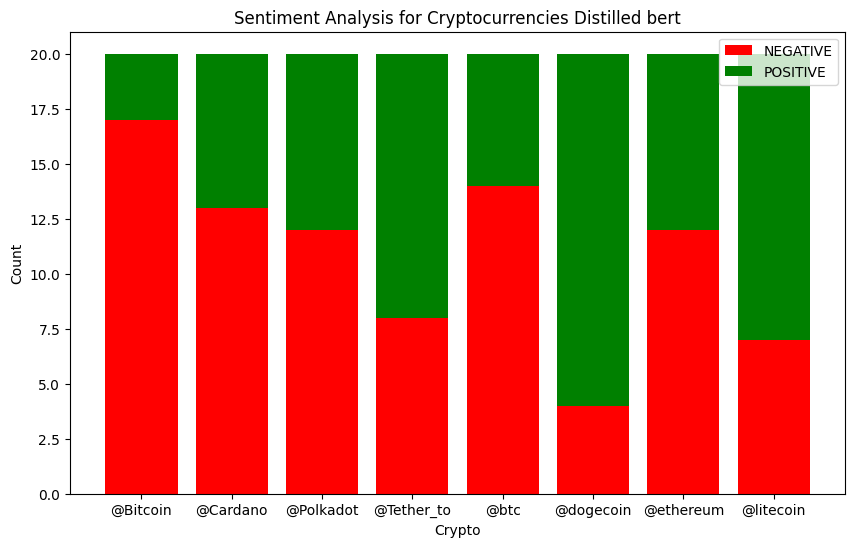

In [194]:
import matplotlib.pyplot as plt

# Group the data by crypto and label, and count the values
new = data.groupby(["crypto", "label"]).size().unstack(fill_value=0)

# Set the colors for positive and negative labels
colors = {"NEGATIVE": "red", "POSITIVE": "green"}

# Plot the bar graph for each crypto
fig, ax = plt.subplots(figsize=(10, 6))
for i, crypto in enumerate(new.index):
    ax.bar(i, new.loc[crypto, "NEGATIVE"], color=colors["NEGATIVE"])
    ax.bar(i, new.loc[crypto, "POSITIVE"], bottom=new.loc[crypto, "NEGATIVE"], color=colors["POSITIVE"])

# Set the x-axis labels as crypto names
ax.set_xticks(range(len(new.index)))
ax.set_xticklabels(new.index)

# Add legends
ax.legend(["NEGATIVE", "POSITIVE"])

# Set the title and axis labels
ax.set_title("Sentiment Analysis for Cryptocurrencies Distilled bert")
ax.set_xlabel("Crypto")
ax.set_ylabel("Count")

plt.show()



#let's Test Which model is Doing well

In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score

# Load the data

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment_textblob'], test_size=0.2, random_state=42)

# Vectorize the text data using a bag-of-words model
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print("textblob","\n",classification_report(y_test, y_pred))
print("textblob","\n",accuracy_score(y_test, y_pred))

textblob 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.67      0.74      0.70        19
    positive       0.45      0.50      0.48        10

    accuracy                           0.59        32
   macro avg       0.37      0.41      0.39        32
weighted avg       0.54      0.59      0.56        32

textblob 
 0.59375


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Evaluating Distilled Bert base-uncased

In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score

# Load the data

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Vectorize the text data using a bag-of-words model
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print("Distilled Bert classification_report","\n",classification_report(y_test, y_pred))
print("Distilled Bert accuracy_score","\n",accuracy_score(y_test, y_pred))


Distilled Bert classification_report 
               precision    recall  f1-score   support

    NEGATIVE       0.57      0.42      0.48        19
    POSITIVE       0.39      0.54      0.45        13

    accuracy                           0.47        32
   macro avg       0.48      0.48      0.47        32
weighted avg       0.50      0.47      0.47        32

Distilled Bert accuracy_score 
 0.46875


**The sentiment analysis models did not work well with Twitter data. Here are a few possible explanations:**

**1-Noisy and informal language**: Twitter is known for its informal language and use of slang, abbreviations, and emojis. Such language can be difficult to analyze for sentiment analysis models, as they are trained on more formal and structured text. As a result, models may not be able to accurately capture the sentiment of tweets.

**2-Irony and sarcasm**: Twitter users often use irony and sarcasm to express their opinions. However, these expressions can be difficult for sentiment analysis models to interpret correctly, leading to inaccurate predictions.

**3-Limited context**: Tweets are short messages with limited context, which can make it challenging for models to accurately determine the sentiment. Without a full understanding of the context and tone of a tweet, it is difficult for models to accurately predict the sentiment.**We have very less data that we can extract from twitter api using personal account**

**4-Data imbalance**: It is possible that the sentiment distribution of the tweets in your dataset is imbalanced, with one sentiment class dominating the dataset. This can result in models being biased towards the dominant sentiment class, leading to poor performance on other sentiment classes.**like the case of roberta**

**5-Model selection**: The performance of a sentiment analysis model depends heavily on the choice of algorithm and its parameters. It is possible that the models you selected were not well-suited for the type of data and sentiment distribution in your dataset, leading to poor performance.